In [ ]:
import numpy as np
import pandas as pd
import torch
from torch import nn
from torch.utils.data import DataLoader, TensorDataset
from sklearn.preprocessing import MinMaxScaler
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.decomposition import PCA


In [7]:
class VRAE(nn.Module):
    def __init__(self, input_dim, hidden_dim=64, latent_dim=20):
        super().__init__()
        self.encoder_rnn = nn.LSTM(input_dim, hidden_dim, batch_first=True)
        self.hidden2mean = nn.Linear(hidden_dim, latent_dim)
        self.hidden2logvar = nn.Linear(hidden_dim, latent_dim)

        self.latent2hidden = nn.Linear(latent_dim, hidden_dim)
        self.decoder_rnn = nn.LSTM(hidden_dim, hidden_dim, batch_first=True)
        self.output_layer = nn.Linear(hidden_dim, input_dim)

    def encode(self, x):
        _, (h_n, _) = self.encoder_rnn(x)
        h_n = h_n.squeeze(0)
        mu = self.hidden2mean(h_n)
        logvar = self.hidden2logvar(h_n)
        return mu, logvar

    def reparameterize(self, mu, logvar):
        std = torch.exp(0.5 * logvar)
        eps = torch.randn_like(std)
        return mu + eps * std

    def decode(self, z, seq_len):
        h_0 = self.latent2hidden(z).unsqueeze(0)
        c_0 = torch.zeros_like(h_0)
        repeated_input = h_0.repeat(seq_len, 1, 1).transpose(0, 1)
        out, _ = self.decoder_rnn(repeated_input, (h_0, c_0))
        return self.output_layer(out)

    def forward(self, x):
        mu, logvar = self.encode(x)
        z = self.reparameterize(mu, logvar)
        x_recon = self.decode(z, x.size(1))
        return x_recon, mu, logvar

# -----------------------------
# Step 3: Train the VRAE
# -----------------------------
"""def loss_function(recon_x, x, mu, logvar):
    recon_loss = nn.MSELoss()(recon_x, x)
    kl_loss = -0.5 * torch.mean(1 + logvar - mu.pow(2) - logvar.exp())
    return recon_loss + kl_loss"""

def loss_function(recon_x, x, mu, logvar, beta=0.01):
    recon_loss = nn.MSELoss()(recon_x, x)
    kl_loss = -0.5 * torch.mean(1 + logvar - mu.pow(2) - logvar.exp())
    return recon_loss + beta * kl_loss

def compare_summary(df1, df2, cols):
    return pd.DataFrame({
        "Original Mean": df1[cols].mean(),
        "Synthetic Mean": df2[cols].mean(),
        "Original Std": df1[cols].std(),
        "Synthetic Std": df2[cols].std(),
        "Original Skew": df1[cols].skew(),
        "Synthetic Skew": df2[cols].skew(),
        "Original Kurt": df1[cols].kurt(),
        "Synthetic Kurt": df2[cols].kurt()
    })


In [ ]:
## DECLARE THESE
epochs = 100
latent_dim = 50
seq_len = 730 # we have two years of data, so that means we have 365 * 2 

In [9]:
df = pd.read_csv("energy_data_panel.csv")

# One-hot categoricals (keep all levels to allow reconstruction later)
cat_cols = ['dwelling_type','income_class','region']
df = pd.get_dummies(df, columns=cat_cols, drop_first=False)

# Feature set to model (you can add/remove)
base_feats = [
    'kwh','high_usage','temperature','price_index','is_weekend','efficiency',
    'treatment','post'
]
oh_feats = [c for c in df.columns if c.startswith('dwelling_type_') or c.startswith('income_class_') or c.startswith('region_')]
feature_cols = base_feats + oh_feats

for col in feature_cols:
    df[col] = df.groupby('house_id')[col].transform(lambda x: x.fillna(x.mean()))
    df[col] = df[col].fillna(df[col].mean())

In [ ]:
panel = df.groupby("house_id").filter(lambda g: len(g) == seq_len)
panel = panel.sort_values(["house_id", "t"])

scalers = {col: MinMaxScaler() for col in feature_cols}
for col in feature_cols:
    panel[col] = scalers[col].fit_transform(panel[[col]])

n_households = panel['house_id'].nunique()
seq_len = seq_len
n_features = len(feature_cols)

X = panel[feature_cols].values.reshape(n_households, seq_len, n_features)
X_tensor = torch.tensor(X, dtype=torch.float32)

model = VRAE(input_dim=n_features,latent_dim=latent_dim)
optimizer = torch.optim.Adam(model.parameters(), lr=1e-3)

loader = DataLoader(TensorDataset(X_tensor), batch_size=64, shuffle=True)
model.train()
for epoch in range(epochs):
    losses = []
    for (x_batch,) in loader:
        optimizer.zero_grad()
        x_recon, mu, logvar = model(x_batch)
        loss = loss_function(x_recon, x_batch, mu, logvar)
        loss.backward()
        optimizer.step()
        losses.append(loss.item())
    print(f"Epoch {epoch+1} - Loss: {np.mean(losses):.4f}")

# Sample synthetic data

model.eval()
with torch.no_grad():
    z = torch.randn(n_households, latent_dim)  # Sample from standard normal
    synthetic = model.decode(z, seq_len).numpy()

# Denormalize + reformat

for i, col in enumerate(feature_cols):
    synthetic[:, :, i] = scalers[col].inverse_transform(synthetic[:, :, i])

syn_df = []
households = df['house_id'].unique()[:synthetic.shape[0]]
for i, house_id in enumerate(households):
    for t in range(seq_len):
        row = dict(house_id=house_id, t=t, date=pd.Timestamp("2023-01-01") + pd.Timedelta(days=t))
        row.update({col: synthetic[i, t, j] for j, col in enumerate(feature_cols)})
        syn_df.append(row)

synthetic_df = pd.DataFrame(syn_df)


Epoch 1 - Loss: 0.2930
Epoch 2 - Loss: 0.2160
Epoch 3 - Loss: 0.1676
Epoch 4 - Loss: 0.1570
Epoch 5 - Loss: 0.1539
Epoch 6 - Loss: 0.1520
Epoch 7 - Loss: 0.1505
Epoch 8 - Loss: 0.1488
Epoch 9 - Loss: 0.1459
Epoch 10 - Loss: 0.1400
Epoch 11 - Loss: 0.1323
Epoch 12 - Loss: 0.1260
Epoch 13 - Loss: 0.1216
Epoch 14 - Loss: 0.1175
Epoch 15 - Loss: 0.1161
Epoch 16 - Loss: 0.1117
Epoch 17 - Loss: 0.1089
Epoch 18 - Loss: 0.1041
Epoch 19 - Loss: 0.1007
Epoch 20 - Loss: 0.0959
Epoch 21 - Loss: 0.0933
Epoch 22 - Loss: 0.0894
Epoch 23 - Loss: 0.0871
Epoch 24 - Loss: 0.0856
Epoch 25 - Loss: 0.0837
Epoch 26 - Loss: 0.0814
Epoch 27 - Loss: 0.0788
Epoch 28 - Loss: 0.0774
Epoch 29 - Loss: 0.0753
Epoch 30 - Loss: 0.0722
Epoch 31 - Loss: 0.0707
Epoch 32 - Loss: 0.0683
Epoch 33 - Loss: 0.0674
Epoch 34 - Loss: 0.0654
Epoch 35 - Loss: 0.0640
Epoch 36 - Loss: 0.0626
Epoch 37 - Loss: 0.0595
Epoch 38 - Loss: 0.0577
Epoch 39 - Loss: 0.0543
Epoch 40 - Loss: 0.0521
Epoch 41 - Loss: 0.0495
Epoch 42 - Loss: 0.0500
E

### Check the synthetic data

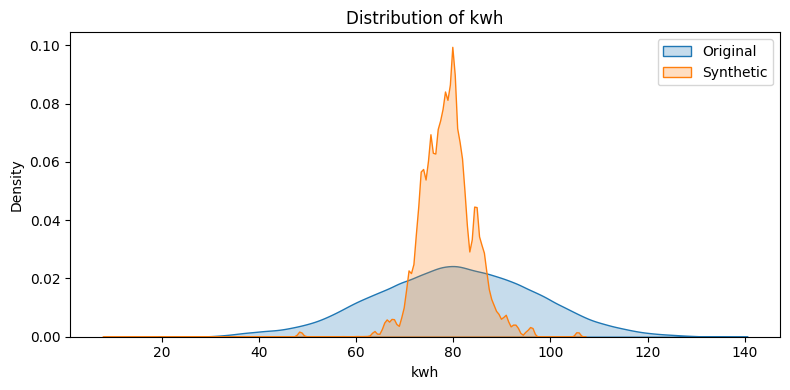

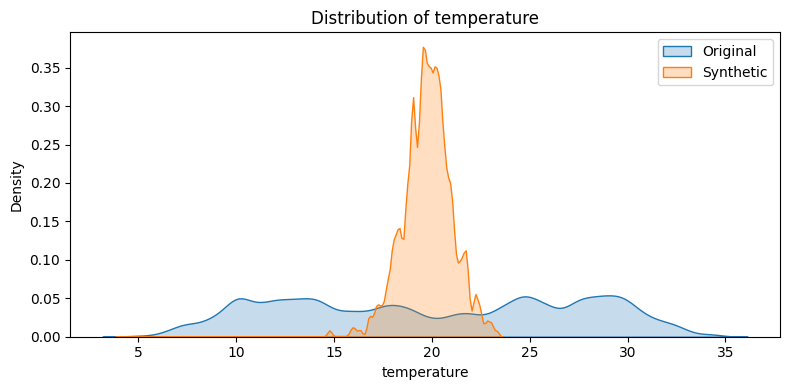

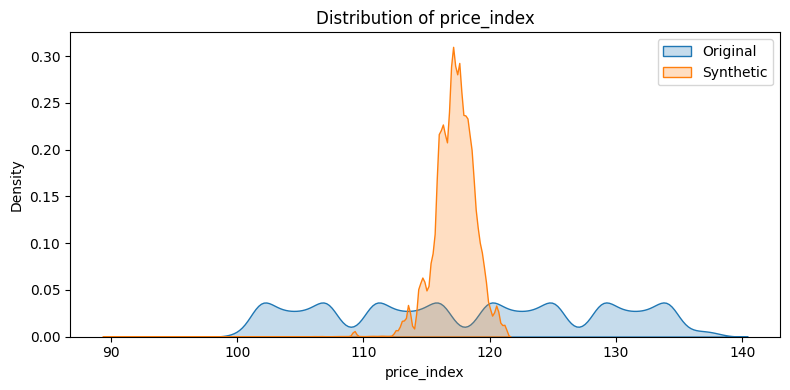

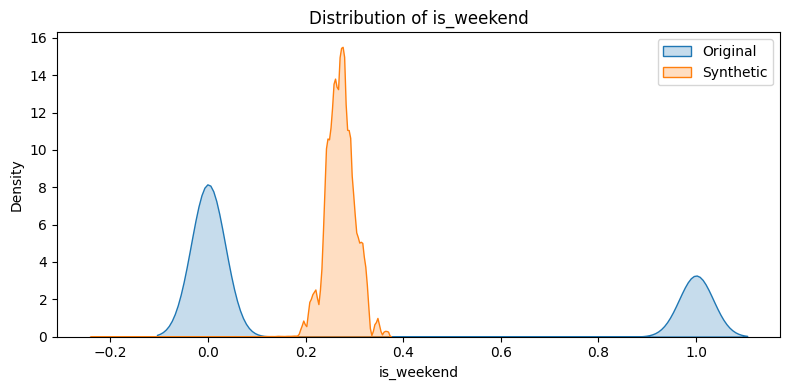

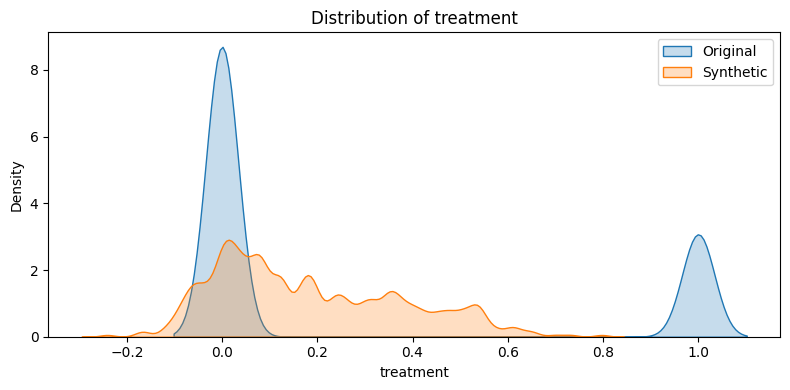

In [11]:
cols_to_plot = ['kwh', 'temperature', 'price_index', 'is_weekend', 'treatment']

for col in cols_to_plot:
    plt.figure(figsize=(8, 4))
    sns.kdeplot(df[col], label="Original", fill=True)
    sns.kdeplot(synthetic_df[col], label="Synthetic", fill=True)
    plt.title(f'Distribution of {col}')
    plt.legend()
    plt.tight_layout()
    plt.show()


In [12]:
summary_stats = compare_summary(df, synthetic_df, cols_to_plot)
print(summary_stats)


             Original Mean  Synthetic Mean  Original Std  Synthetic Std  \
kwh              80.301083       78.731438     16.668444       5.768856   
temperature      19.998168       19.750374      7.369127       1.317381   
price_index     118.235661      117.150345     10.469988       1.745763   
is_weekend        0.286301        0.269880      0.452033       0.032511   
treatment         0.261055        0.180814      0.439210       0.195432   

             Original Skew  Synthetic Skew  Original Kurt  Synthetic Kurt  
kwh              -0.061693       -0.668976      -0.132374        7.454794  
temperature      -0.017072       -0.927602      -1.282936        5.867107  
price_index       0.007687       -2.237458      -1.225050       17.359482  
is_weekend        0.945506       -1.752069      -1.106024       16.528755  
treatment         1.088073        0.578437      -0.816101       -0.528872  


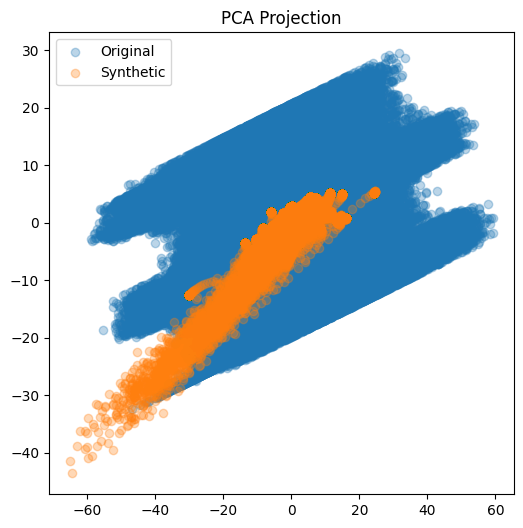

In [ ]:
pca = PCA(n_components=2)
original_pca = pca.fit_transform(df[cols_to_plot])
synthetic_pca = pca.transform(synthetic_df[cols_to_plot])

plt.figure(figsize=(6, 6))
plt.scatter(original_pca[:, 0], original_pca[:, 1], alpha=0.3, label="Original")
plt.scatter(synthetic_pca[:, 0], synthetic_pca[:, 1], alpha=0.3, label="Synthetic")
plt.title("PCA Projection")
plt.legend()
plt.show()
